# Signal Decomposition: Method Comparison

Comparing four decomposition approaches:
1. **Savitzky-Golay + Butterworth cleanup**
2. **Pure Butterworth**
3. **VMD (Two-Stage)**
4. **STL (LOESS)**

In [ ]:
from __future__ import annotations

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from rubin_vmd_decomposer import RubinVMDDecomposer
from signal_decomposer_v3 import SignalDecomposer
from stl_decomposer import STLDecomposer


np.random.seed(42)
plt.rcParams["figure.figsize"] = (16, 8)
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.alpha"] = 0.3

## 2. Generate Synthetic Signal

In [ ]:
dates = pd.date_range("2023-01-01", "2023-07-01", freq="15min")
n = len(dates)
t = np.arange(n)
freq = 96

# Components
subdaily_cycle = 3 * np.sin(2 * np.pi * t / (freq * 0.5))  # 12h
daily_cycle = 5 * np.sin(2 * np.pi * t / freq)  # 24h
weekly_cycle = 2 * np.sin(2 * np.pi * t / (freq * 7))  # 7d
monthly_cycle = 1 * np.sin(2 * np.pi * t / (freq * 28))  # 28d
noise = 0.5 * np.random.randn(n)
trend = 5 + 4 * t / (96 * 24 * 7)

y = subdaily_cycle + daily_cycle + weekly_cycle + monthly_cycle + noise + trend

df = pd.DataFrame(
    {
        "ds": dates,
        "y": y,
        "subdaily_true": subdaily_cycle,
        "daily_true": daily_cycle,
        "weekly_true": weekly_cycle,
        "monthly_true": monthly_cycle,
        "noise_true": noise,
        "trend_true": trend,
    }
)

print(f"Generated {len(df):,} observations ({len(df) / freq:.1f} days)")
print("\nComponent amplitudes:")
print("  Sub-daily (12h): 3")
print("  Daily (24h):     5")
print("  Weekly (7d):     2")
print("  Monthly (28d):   1")
print("  Noise std:       0.5")
print("  Trend:           5 + 4*t/week")

Generated 17,377 observations (181.0 days)

Component amplitudes:
  Sub-daily (12h): 3
  Daily (24h):     5
  Weekly (7d):     2
  Monthly (28d):   1
  Noise std:       0.5
  Trend:           5 + 4*t/week


## 3. Visualize True Components

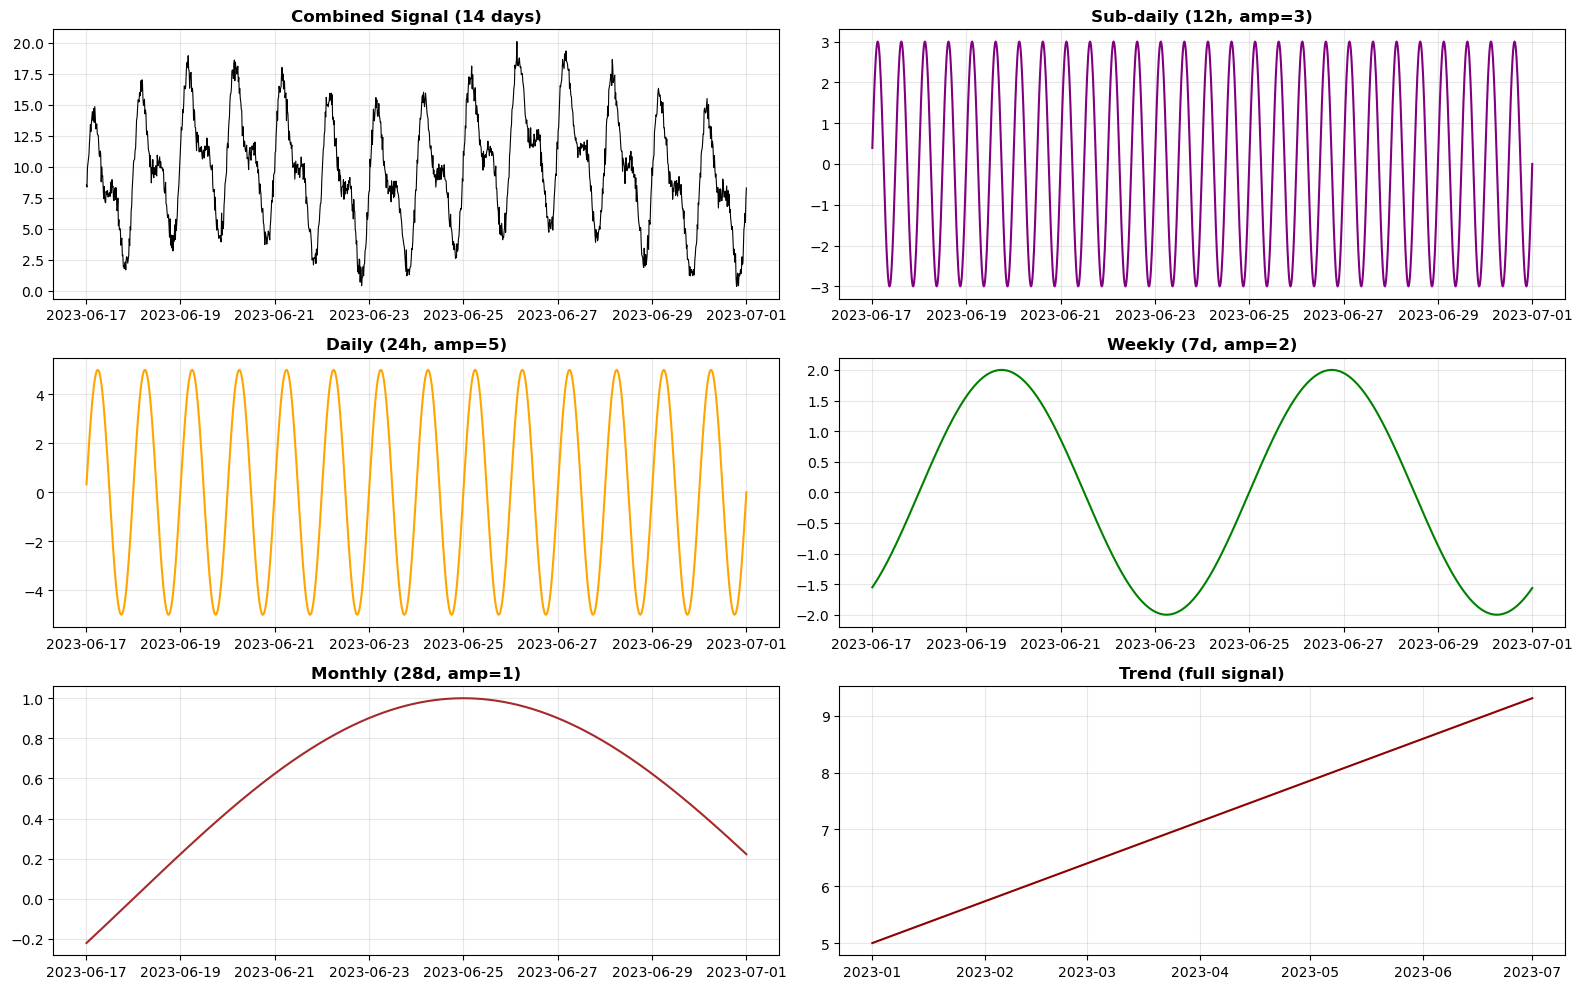

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(16, 10))

plot_days = 14
plot_n = plot_days * freq

axes[0, 0].plot(df["ds"][-plot_n:], df["y"][-plot_n:], "k", lw=0.8)
axes[0, 0].set_title("Combined Signal (14 days)", fontweight="bold")

axes[0, 1].plot(df["ds"][-plot_n:], df["subdaily_true"][-plot_n:], "purple", lw=1.5)
axes[0, 1].set_title("Sub-daily (12h, amp=3)", fontweight="bold")

axes[1, 0].plot(df["ds"][-plot_n:], df["daily_true"][-plot_n:], "orange", lw=1.5)
axes[1, 0].set_title("Daily (24h, amp=5)", fontweight="bold")

axes[1, 1].plot(df["ds"][-plot_n:], df["weekly_true"][-plot_n:], "green", lw=1.5)
axes[1, 1].set_title("Weekly (7d, amp=2)", fontweight="bold")

axes[2, 0].plot(df["ds"][-plot_n:], df["monthly_true"][-plot_n:], "brown", lw=1.5)
axes[2, 0].set_title("Monthly (28d, amp=1)", fontweight="bold")

axes[2, 1].plot(df["ds"], df["trend_true"], "darkred", lw=1.5)
axes[2, 1].set_title("Trend (full signal)", fontweight="bold")

plt.tight_layout()
plt.show()

## 4. Apply All Decomposition Methods

In [ ]:
# Period pairs for SavGol and Butterworth
period_pairs = [
    (0.25, 0.75),  # Sub-daily
    (0.75, 1.25),  # Daily
    (1.5, 9.0),  # Weekly
    (9.0, 30.0),  # Monthly
    (30.0, 180.0),  # Trend
]

# Periods for STL
stl_periods = [0.5, 1.0, 7.0, 28.0]

print("Configuration:")
print(f"  SavGol/Butterworth period_pairs: {period_pairs}")
print(f"  STL periods: {stl_periods}")
print("  VMD: Daily [0.75,1.25], Weekly [1.5,7], Monthly [7,30], Trend [30,200]")

Configuration:
  SavGol/Butterworth period_pairs: [(0.25, 0.75), (0.75, 1.25), (1.5, 9.0), (9.0, 30.0), (30.0, 180.0)]
  STL periods: [0.5, 1.0, 7.0, 28.0]
  VMD: Daily [0.75,1.25], Weekly [1.5,7], Monthly [7,30], Trend [30,200]


In [ ]:
# 1. SavGol + Butterworth
decomposer_sg = SignalDecomposer(
    freq=freq,
    period_pairs=period_pairs,
    filter_type="savgol",
    savgol_butter_cleanup=True,
    savgol_butter_margin=0.1,
    mode="keep",
    edge_method="symmetric",
    edge_pad_periods=1.0,
)
df_sg = decomposer_sg.decompose(df[["ds", "y"]].copy())


Signal Decomposition - SAVGOL
Data frequency: 96 obs/day
Data length: 17377 observations (181.0 days)
Edge method: symmetric (pad=1.0 periods)
Edge weighting: False
Number of bands: 5

Computing band_0 (0.25-0.75d, windows=[37, 109], pad=72)...
Computing band_1 (0.75-1.25d, windows=[109, 181], pad=120)...
Computing band_2 (1.50-9.00d, windows=[217, 1297], pad=864)...
Computing band_3 (9.00-30.00d, windows=[1297, 4321], pad=2880)...
Computing band_4 (30.00-180.00d, windows=[4321, 25921], pad=17280)...

Decomposition complete. Shape: (17377, 7)



In [ ]:
# 2. Butterworth
decomposer_bw = SignalDecomposer(
    freq=freq,
    period_pairs=period_pairs,
    filter_type="butterworth",
    butter_order=4,
    mode="keep",
    edge_method="symmetric",
    edge_pad_periods=1.0,
)
df_bw = decomposer_bw.decompose(df[["ds", "y"]].copy())


Signal Decomposition - BUTTERWORTH
Data frequency: 96 obs/day
Data length: 17377 observations (181.0 days)
Edge method: symmetric (pad=1.0 periods)
Edge weighting: False
Number of bands: 5

Computing band_0 (0.25-0.75d, freqs=[0.0278, 0.0833], pad=72)...
Computing band_1 (0.75-1.25d, freqs=[0.0167, 0.0278], pad=120)...
Computing band_2 (1.50-9.00d, freqs=[0.0023, 0.0139], pad=864)...
Computing band_3 (9.00-30.00d, freqs=[0.0010, 0.0023], pad=2880)...
Computing band_4 (30.00-180.00d, freqs=[0.0008, 0.0012], pad=17280)...

Decomposition complete. Shape: (17377, 7)



In [ ]:
# 3. VMD
decomposer_vmd = RubinVMDDecomposer(
    freq=freq, alpha=2000, K_stage1=5, K_stage2=3, butter_order=4, butter_margin=0.1
)
df_vmd = decomposer_vmd.decompose(df[["ds", "y"]].copy())


Rubin VMD Decomposition
Data frequency: 96 obs/day
Data length: 17377 observations (181.0 days)
VMD alpha: 2000

STAGE 1: VMD on original signal (K=5)...
  ✓ Extracted IMF1 (lowest frequency mode)
  IMF1 std: 1.9964

Applying Butterworth bandpass to IMF1...
  Computing vmd_weekly (1.50-9.0d)...
  Computing vmd_monthly (21.00-38.0d)...
  Computing vmd_trend (30.00-200.0d)...

STAGE 2: VMD on residual signal (K=3)...
  Residual std: 4.3963
  ✓ Extracted sub-daily (IMF2, std: 2.1266)
  ✓ Extracted IMF3 / noise (std: 0.1346)
  (IMF1 from residual discarded)

Decomposition complete!

Output components (high freq → low freq):
  1. y_imf3        : Highest freq / noise (from residual VMD)
  2. y_subdaily    : Sub-daily component (IMF2 from residual VMD)
  3. y_vmd_daily   : (0.5, 2.0) days (Butterworth on IMF1)
  4. y_vmd_weekly  : (1.5, 9.0) days (Butterworth on IMF1)
  5. y_vmd_monthly : (21.0, 38.0) days (Butterworth on IMF1)
  6. y_vmd_trend   : (30.0, 200.0) days (Butterworth on IMF1)

D

In [ ]:
# 4. STL
decomposer_stl = STLDecomposer(freq=freq, periods=stl_periods, mode="keep", robust=False)
df_stl = decomposer_stl.decompose(df[["ds", "y"]].copy())


Signal Decomposition - STL (LOESS) Method
Data frequency: 96 obs/day
Data length: 17377 observations (181.0 days)
Periods to extract: [0.5, 1.0, 7.0, 28.0] days
Robust: False

Computing period_0.5d (period=0.5d, 48 obs)...
  → Extracted seasonal (std=2.1182)
Computing period_1.0d (period=1.0d, 96 obs)...
  → Extracted seasonal (std=3.5441)
Computing period_7.0d (period=7.0d, 672 obs)...
  → Extracted seasonal (std=1.4244)
Computing period_28.0d (period=28.0d, 2688 obs)...
  → Extracted seasonal (std=0.7487)
Computing trend (remaining signal)...
  → Trend (std=1.3113)

Decomposition complete. Dataset shape: (17377, 7)



## 5. Compare All Methods

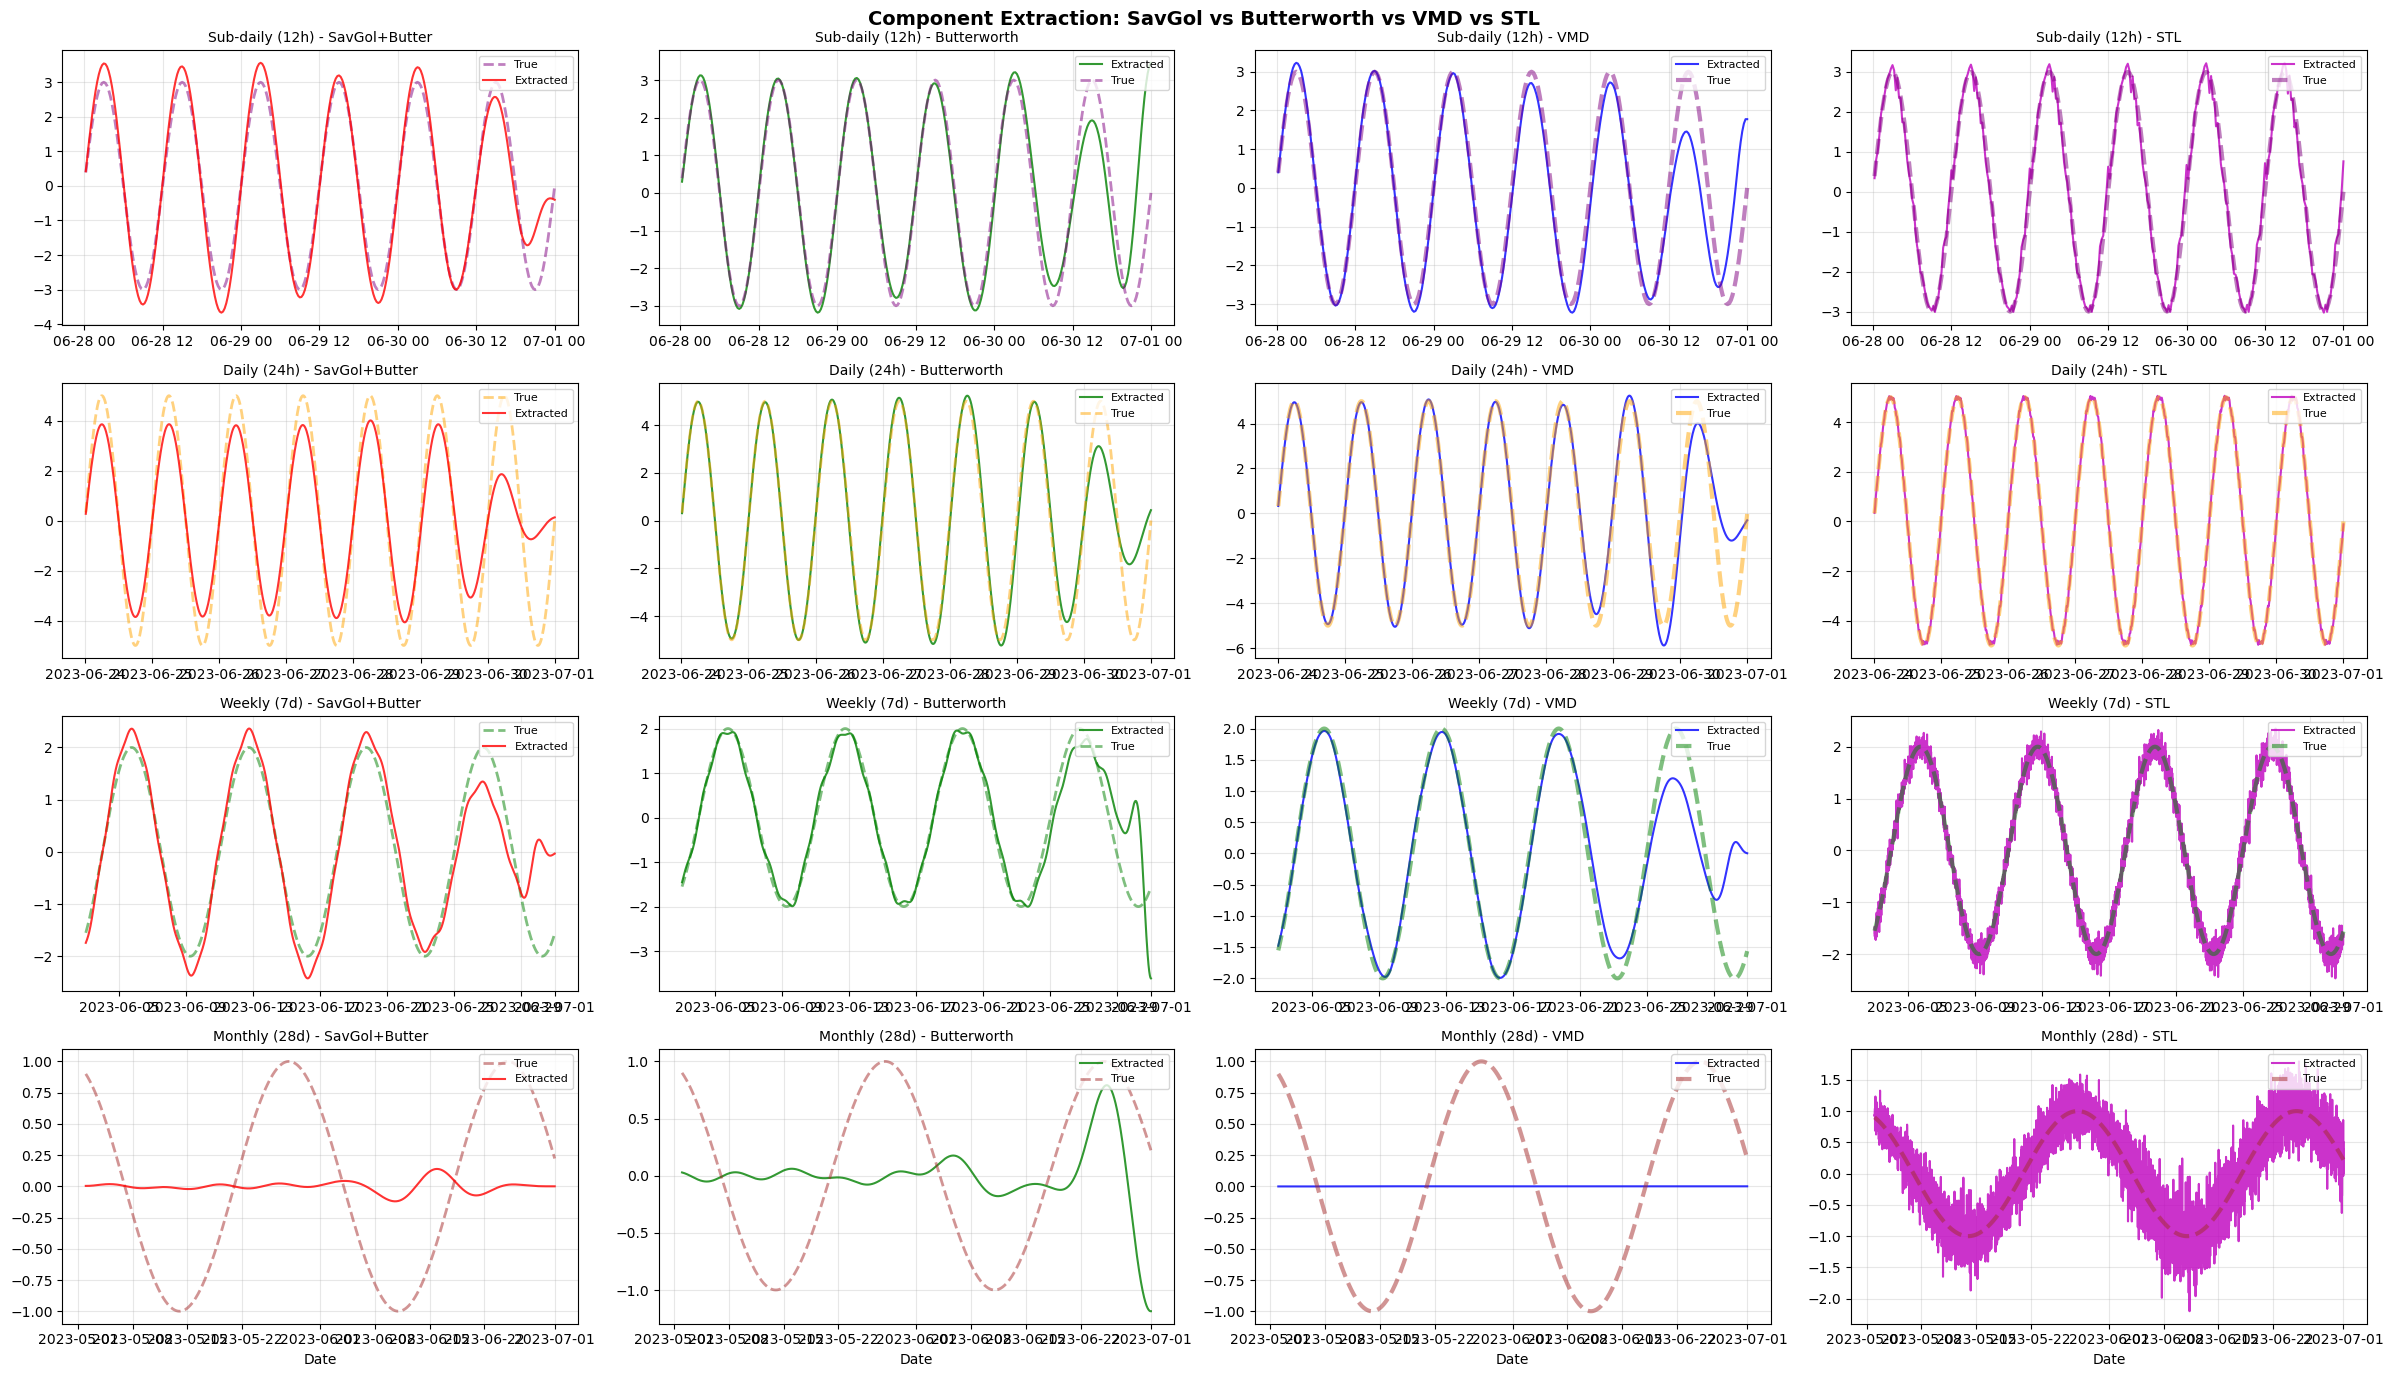

In [ ]:
# Mapping: (true_col, sg_col, vmd_col, stl_col, title, color, plot_days)
comparisons = [
    ("subdaily_true", "y_band_0", "y_subdaily", "y_period_0.5d", "Sub-daily (12h)", "purple", 3),
    ("daily_true", "y_band_1", "y_vmd_daily", "y_period_1.0d", "Daily (24h)", "orange", 7),
    ("weekly_true", "y_band_2", "y_vmd_weekly", "y_period_7.0d", "Weekly (7d)", "green", 28),
    ("monthly_true", "y_band_3", "y_vmd_monthly", "y_period_28.0d", "Monthly (28d)", "brown", 60),
]

fig, axes = plt.subplots(4, 4, figsize=(24, 14))
fig.suptitle(
    "Component Extraction: SavGol vs Butterworth vs VMD vs STL", fontsize=14, fontweight="bold"
)

for i, (true_col, sg_col, vmd_col, stl_col, title, color, plot_days) in enumerate(comparisons):
    plot_n = min(plot_days * freq, len(df))

    # SavGol
    axes[i, 0].plot(
        df["ds"][-plot_n:], df[true_col][-plot_n:], "--", color=color, lw=2, alpha=0.5, label="True"
    )
    axes[i, 0].plot(
        df_sg["ds"][-plot_n:], df_sg[sg_col][-plot_n:], "r", lw=1.5, alpha=0.8, label="Extracted"
    )
    axes[i, 0].set_title(f"{title} - SavGol+Butter", fontsize=10)
    axes[i, 0].legend(loc="upper right", fontsize=8)

    # Butterworth
    axes[i, 1].plot(
        df_bw["ds"][-plot_n:], df_bw[sg_col][-plot_n:], "g", lw=1.5, alpha=0.8, label="Extracted"
    )
    axes[i, 1].plot(
        df["ds"][-plot_n:], df[true_col][-plot_n:], "--", color=color, lw=2, alpha=0.5, label="True"
    )
    axes[i, 1].set_title(f"{title} - Butterworth", fontsize=10)
    axes[i, 1].legend(loc="upper right", fontsize=8)

    # VMD
    axes[i, 2].plot(
        df_vmd["ds"][-plot_n:], df_vmd[vmd_col][-plot_n:], "b", lw=1.5, alpha=0.8, label="Extracted"
    )
    axes[i, 2].plot(
        df["ds"][-plot_n:], df[true_col][-plot_n:], "--", color=color, lw=3, alpha=0.5, label="True"
    )
    axes[i, 2].set_title(f"{title} - VMD", fontsize=10)
    axes[i, 2].legend(loc="upper right", fontsize=8)

    # STL
    axes[i, 3].plot(
        df_stl["ds"][-plot_n:], df_stl[stl_col][-plot_n:], "m", lw=1.5, alpha=0.8, label="Extracted"
    )
    axes[i, 3].plot(
        df["ds"][-plot_n:], df[true_col][-plot_n:], "--", color=color, lw=3, alpha=0.5, label="True"
    )
    axes[i, 3].set_title(f"{title} - STL", fontsize=10)
    axes[i, 3].legend(loc="upper right", fontsize=8)

for ax in axes[-1, :]:
    ax.set_xlabel("Date")

plt.tight_layout()
plt.savefig("component_extraction_comparison.png", dpi=120)
plt.show()

## 6. Trend Comparison

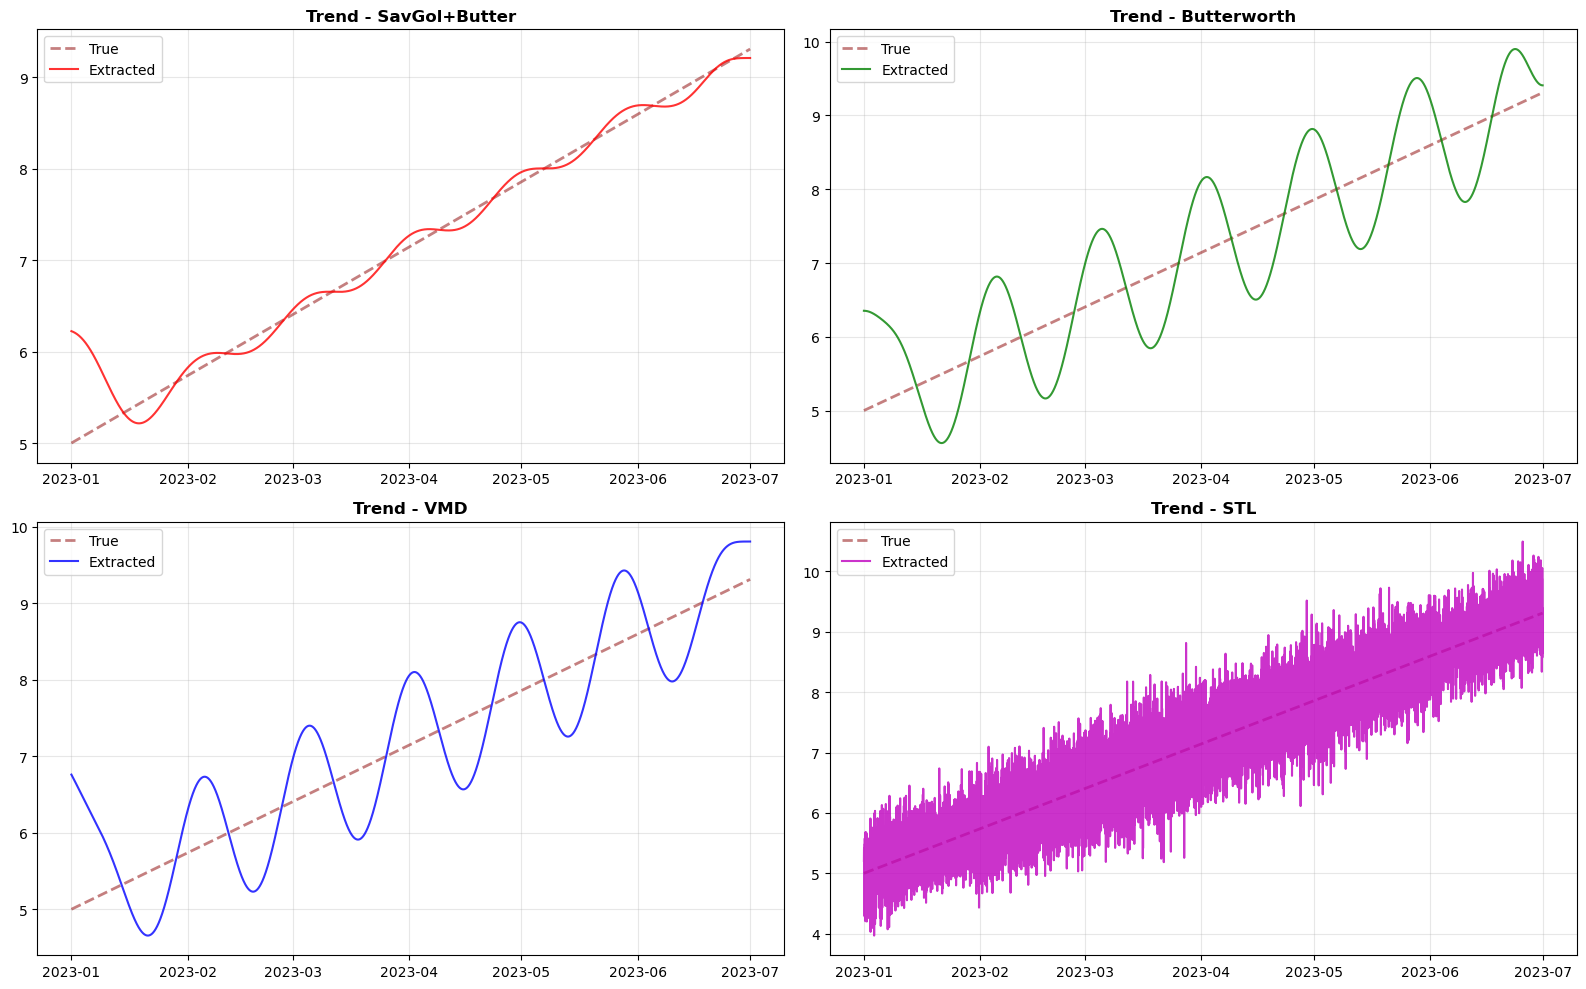

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# SavGol
axes[0, 0].plot(df["ds"], df["trend_true"], "--", color="darkred", lw=2, alpha=0.5, label="True")
axes[0, 0].plot(df_sg["ds"], df_sg["y_band_4"], "r", lw=1.5, alpha=0.8, label="Extracted")
axes[0, 0].set_title("Trend - SavGol+Butter", fontsize=12, fontweight="bold")
axes[0, 0].legend()

# Butterworth
axes[0, 1].plot(df["ds"], df["trend_true"], "--", color="darkred", lw=2, alpha=0.5, label="True")
axes[0, 1].plot(df_bw["ds"], df_bw["y_band_4"], "g", lw=1.5, alpha=0.8, label="Extracted")
axes[0, 1].set_title("Trend - Butterworth", fontsize=12, fontweight="bold")
axes[0, 1].legend()

# VMD
axes[1, 0].plot(df["ds"], df["trend_true"], "--", color="darkred", lw=2, alpha=0.5, label="True")
axes[1, 0].plot(df_vmd["ds"], df_vmd["y_vmd_trend"], "b", lw=1.5, alpha=0.8, label="Extracted")
axes[1, 0].set_title("Trend - VMD", fontsize=12, fontweight="bold")
axes[1, 0].legend()

# STL
axes[1, 1].plot(df["ds"], df["trend_true"], "--", color="darkred", lw=2, alpha=0.5, label="True")
axes[1, 1].plot(df_stl["ds"], df_stl["y_trend"], "m", lw=1.5, alpha=0.8, label="Extracted")
axes[1, 1].set_title("Trend - STL", fontsize=12, fontweight="bold")
axes[1, 1].legend()

plt.tight_layout()
plt.show()

## 7. Summary Statistics (RMSE)

In [ ]:
print("=" * 100)
print("COMPONENT EXTRACTION ACCURACY (RMSE) - Lower is better")
print("=" * 100)
print(f"{'Component':<20} {'SavGol+Butter':<18} {'Butterworth':<18} {'VMD':<18} {'STL':<18}")
print("-" * 100)

for true_col, sg_col, vmd_col, stl_col, name, _, _ in comparisons:
    rmse_sg = np.sqrt(np.mean((df_sg[sg_col] - df[true_col]) ** 2))
    rmse_bw = np.sqrt(np.mean((df_bw[sg_col] - df[true_col]) ** 2))
    rmse_vmd = np.sqrt(np.mean((df_vmd[vmd_col] - df[true_col]) ** 2))
    rmse_stl = np.sqrt(np.mean((df_stl[stl_col] - df[true_col]) ** 2))
    print(f"{name:<20} {rmse_sg:<18.4f} {rmse_bw:<18.4f} {rmse_vmd:<18.4f} {rmse_stl:<18.4f}")

# Trend
rmse_sg = np.sqrt(np.mean((df_sg["y_band_4"] - df["trend_true"]) ** 2))
rmse_bw = np.sqrt(np.mean((df_bw["y_band_4"] - df["trend_true"]) ** 2))
rmse_vmd = np.sqrt(np.mean((df_vmd["y_vmd_trend"] - df["trend_true"]) ** 2))
rmse_stl = np.sqrt(np.mean((df_stl["y_trend"] - df["trend_true"]) ** 2))
print(f"{'Trend':<20} {rmse_sg:<18.4f} {rmse_bw:<18.4f} {rmse_vmd:<18.4f} {rmse_stl:<18.4f}")

print("=" * 100)

COMPONENT EXTRACTION ACCURACY (RMSE) - Lower is better
Component            SavGol+Butter      Butterworth        VMD                STL               
----------------------------------------------------------------------------------------------------
Sub-daily (12h)      0.3378             0.1848             0.2438             0.0928            
Daily (24h)          0.8559             0.2339             0.2112             0.0490            
Weekly (7d)          0.3198             0.2628             0.2600             0.1306            
Monthly (28d)        0.7088             0.7177             0.7090             0.2394            
Trend                0.2332             0.7052             0.6671             0.4052            


## 8. Conclusions

### Method Comparison

| Method | Pros | Cons | Best For |
|--------|------|------|----------|
| **SavGol+Butter** | Smooth output, good frequency control | May attenuate at band edges | Known periodic signals |
| **Butterworth** | Sharp frequency cutoffs, precise | Can have ringing | Precise bandpass |
| **VMD** | Adaptive, data-driven | Needs tuning, slower | Non-stationary signals |
| **STL** | Robust to outliers, interpretable | Less precise frequency control | Exploratory analysis |

### Recommendations

1. **For known periodic signals** (temperature forecasting): Use **Butterworth** or **SavGol+Butter**
2. **For exploratory analysis**: Use **STL** with `robust=True`
3. **For non-stationary data**: Consider **VMD** with tuned parameters
4. **For production pipelines**: **Butterworth** is fast and reliable